In [1]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, GlobalAveragePooling1D, Dropout
from tensorflow.keras.utils import text_dataset_from_directory
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

import pandas as pd
import re
import plotly.graph_objects as go
import datetime
import os


In [2]:
# Setup some initial parameters
batch_size = 64
validation_ratio = 0.2
seed = 42
max_features = 1000
sequence_length = 500

In [3]:
# Load datasets
raw_train_ds = text_dataset_from_directory(
    "temp/train",
    batch_size=batch_size,
    validation_split=validation_ratio,
    subset='training',
    seed=seed
)
raw_val_ds = text_dataset_from_directory(
    'temp/train',
    batch_size=batch_size,
    validation_split=validation_ratio,
    subset='validation',
    seed=seed
)
raw_test_ds = text_dataset_from_directory(
    'temp/test',
    batch_size=batch_size
)

Found 3124 files belonging to 131 classes.
Using 2500 files for training.
Found 3124 files belonging to 131 classes.
Using 624 files for validation.
Found 347 files belonging to 80 classes.


In [4]:
# Define a custom text standardization function to preprocess text data
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html, '[%s]' % re.escape('!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'), '')

In [5]:
# Create a TextVectorization layer to vectorize text
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=sequence_length
)
vectorize_layer.adapt(raw_train_ds.map(lambda text, label: text))

In [6]:
# Define the model architecture
model = Sequential([
    vectorize_layer,
    Embedding(max_features + 1, 16),
    LSTM(32, return_sequences=True),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    GlobalAveragePooling1D(),
    Dropout(0.2),
    Dense(1)  # Output layer for regression; no activation function
])

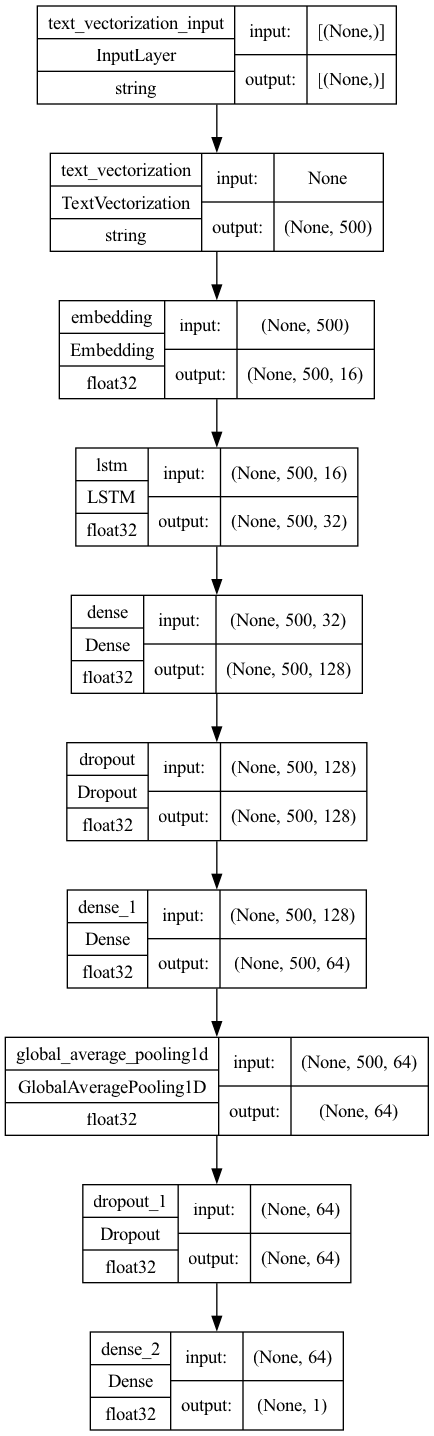

In [7]:
import tensorflow as tf


plot_model(model, to_file='model_diagram.png', show_shapes=True, show_layer_names=True, show_dtype=True)


In [161]:
# Compile the model
model.compile(
    loss="mean_absolute_error",  # Using MSE for regression
    optimizer="adam",
    metrics=["mean_absolute_error"]  # Using MAE as a metric for regression
)

In [162]:
# Set the directory to store the logs
log_dir = os.path.join("logs", "fit", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=0)

In [163]:
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

In [164]:
# Train the model
epochs = 100
history = model.fit(
    raw_train_ds,
    validation_data=raw_val_ds,
    epochs=epochs,
    callbacks=[tensorboard_callback, early_stopping_callback]
)

Epoch 1/100


40/40 [==============================] - 4s 94ms/step - loss: 51.5462 - mean_absolute_error: 51.5462 - val_loss: 35.0607 - val_mean_absolute_error: 35.0607
Epoch 2/100
40/40 [==============================] - 3s 75ms/step - loss: 23.6042 - mean_absolute_error: 23.6042 - val_loss: 22.0546 - val_mean_absolute_error: 22.0546
Epoch 3/100
40/40 [==============================] - 3s 76ms/step - loss: 22.5218 - mean_absolute_error: 22.5218 - val_loss: 21.8123 - val_mean_absolute_error: 21.8123
Epoch 4/100
40/40 [==============================] - 3s 76ms/step - loss: 22.4431 - mean_absolute_error: 22.4431 - val_loss: 21.8601 - val_mean_absolute_error: 21.8601
Epoch 5/100
40/40 [==============================] - 3s 76ms/step - loss: 22.3969 - mean_absolute_error: 22.3969 - val_loss: 21.8888 - val_mean_absolute_error: 21.8888
Epoch 6/100
40/40 [==============================] - 3s 77ms/step - loss: 22.2276 - mean_absolute_error: 22.2276 - val_loss: 21.8468 - val_mean_absolute_error: 21.8468
Epoc

In [166]:
# Creating a line plot for training and validation loss using Plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(len(history.history['loss']))), 
                         y=history.history['loss'], 
                         mode='lines',
                         name='Training Loss'))
fig.add_trace(go.Scatter(x=list(range(len(history.history['val_loss']))), 
                         y=history.history['val_loss'], 
                         mode='lines',
                         name='Validation Loss'))

# Updating the layout of the plot
fig.update_layout(title='Loss over Epochs',
                  xaxis_title='Epochs',
                  yaxis_title='Loss',
                  legend_title='Legend')

# Display the plot
fig.show()

In [150]:
# Evaluate the model
model.evaluate(raw_test_ds)

6/6 [==============================] - 0s 8ms/step - loss: 1147.5656 - mean_absolute_error: 29.9468


[1147.5655517578125, 29.946840286254883]

In [123]:
# Prepare lists to hold the data
texts = []
actual_labels = []
predicted_labels = []

# Iterate over the entire test dataset
for text_batch, label_batch in raw_test_ds:
    # Make predictions for the current batch
    predictions = model.predict(text_batch)
    # Decode text data if it's in bytes format and store in the list
    texts.extend([text.numpy().decode('utf-8') for text in text_batch])
    # Store actual labels and predictions
    actual_labels.extend(label_batch.numpy())
    predicted_labels.extend(predictions.flatten())  # Flatten in case the predictions have an extra dimension

# Create a DataFrame from the collected data
data = {
    "Text": texts,
    "Actual Label": actual_labels,
    "Predicted Label": predicted_labels
}
df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
csv_file_path = "model_predictions.csv"
df.to_csv(csv_file_path, index=False)

print(f"All predictions saved to {csv_file_path}")

1/1 [==============================] - 0s 52ms/step
All predictions saved to model_predictions.csv
